In [1]:

from scipy.optimize import minimize

from functools import partial
from scipy.interpolate import interp1d

In [2]:
import numpy as np
import pandas as pd
#from ct import app,db
#from ct.models import *
#from ct.utils import *
from IPython.display import display, HTML
from IPython.display import IFrame as iframe

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import qgrid
gr=qgrid.show_grid
pd.core.frame.DataFrame.gr=gr
import requests
#from ct.fs import SequentialFeatureSelector,BorutaPy
#from ct.fs import TimeSeriesSplit,runselector,fs1
%matplotlib inline
# if qgrid not shown run and restar jupyter:
#jupyter nbextension enable --py --sys-prefix qgrid
#jupyter nbextension enable --py --sys-prefix widgetsnbextension
#
#

In [3]:
import sys
sys.path.insert(1,"/core/github/cryptoderiv-quant-lib")

In [4]:
import pandas as pd
from datetime import datetime
import json
import cryptoderiv_quantlib as cq
from pytest import approx
from tests import utils as test_utils
from cryptoderiv_quantlib import VolModels
from cryptoderiv_quantlib import VolCurve, VolSurface, StickyOptions

In [5]:
# df0 = pd.read_pickle("bt_spikeDec_MAR22.pkl")
df0 = pd.read_pickle("/core/data/bt_spikeDec_DEC21.pkl")
#df0 = df0.append(pd.read_pickle("bt_spikeDec_DEC21.pkl"))

In [6]:
df1 = df0[['tm','expire','strike','ty','s','aiv','biv','vega']].reset_index(drop=True).sort_values(by=['tm','expire','strike']).drop_duplicates().reset_index(drop=True)
df1['params'] = [{} for i in range(len(df1))]
df1['tm'] = [int(df1['tm'][i].timestamp()*1000) for i in range(len(df1))]
df1['expire'] = [int(df1['expire'][i].timestamp()*1000) for i in range(len(df1))]

In [ ]:
#df1['tm'] = pd.to_datetime(df1['tm'], unit='ms')

In [ ]:
df1

In [8]:
#df = df1[df1.tm<=1638316800000+60000*0].set_index(['tm','expire','strike'])
df = df1.set_index(['tm','expire','strike'])
df

ty         s     aiv     biv      vega  \
tm            expire        strike                                            
1638316800000 1640937600000 22000.0  -1  57406.67  1.4606  1.3408   2.40936   
                            24000.0  -1  57439.75  1.3375  1.2269   2.60587   
                            26000.0  -1  57445.90  1.2237  1.1215   2.82325   
                            28000.0   1  57405.11  1.3393  0.9508   3.60124   
                            28000.0  -1  57432.07  1.1836  1.0235   3.59046   
...                                  ..       ...     ...     ...       ...   
1639526340000 1640937600000 65000.0  -1  48531.90  1.1061  0.6188  15.75853   
                            70000.0   1  48531.64  1.0095  0.9371   9.99838   
                            75000.0   1  48530.70  1.0436  0.9655   6.21534   
                            80000.0   1  48530.89  1.1280  1.0251   4.63792   
                            85000.0   1  48530.22  1.1286  1.0399   2.72112   

                                    params  
tm            expire        strike          
1638316800000 1640937600000 22000.0     {}  
                            24000.0     {}  
                            26000.0     {}  
                            28000.0     {}  
                            28000.0     {}  
...                                    ...  
1639526340000 1640937600000 65000.0     {}  
                            70000.0     {}  
                            75000.0     {}  
                            80000.0     {}  
                            85000.0     {}  

[827697 rows x 6 columns]

In [9]:
def step_err(aiv, biv, myiv):
    aiv = np.array(aiv)
    biv = np.array(biv)
    myiv = np.array(myiv)
    miv = 0.5 * (aiv + biv)
    halfspread = 0.5 * np.abs(aiv - biv)
    raw_err = np.abs(myiv - miv) 
    squared_err = raw_err * raw_err 
    step_err = raw_err + 999*(raw_err>halfspread)*(raw_err)
    squared_step_err = step_err * step_err
    return raw_err, step_err, squared_err, squared_step_err

In [10]:
#a.curves[0].params
#dir(a.curves[0])


In [11]:
def err_fun2(curve,df,useprevATMvol=True):
    x = [curve.params['skew_left'], curve.params['skew_right'], 
         curve.params['conv_left'], curve.params['conv_right'], 
         curve.params['rightwing'], curve.params['leftwing'], curve.params['vol_atm']]
        
    return err_fun3(x,df,useprevATMvol=True)
    
def err_fun3(x,df,useprevATMvol=True):
    skewleft=x[0]
    skewright=x[1]
    leftconv=x[2]
    rightconv=x[3]
    rightwing=x[4]
    leftwing=x[5]
    
    df['m'] = 0.5*(df['aiv']+df['biv'])
    S=df['s'].iloc[0]
    if useprevATMvol:
        volATM = x[6]
    else:
        volATM=interp1d(df.index, df['m'])([S])[0]

    kwargs = model._default_vol_model_config()
    kright=kwargs['kright']
    kleft=kwargs['kleft']
    
    df.loc[(df.logKFtau>=0)&(df.logKFtau<kright),'myvol']=volATM+(skewright*df['logKFtau']+rightconv*df['logKFtau']**2)
    df.loc[(df.logKFtau<0)&(df.logKFtau>kleft),'myvol']=volATM+(-skewleft*df['logKFtau']+leftconv*df['logKFtau']**2)
    yright=volATM+(skewright*kright+rightconv*kright**2)
    yleft=volATM+(-skewleft*kleft+leftconv*kleft**2)
    df.loc[(df.logKFtau>=kright),'myvol']=rightwing*(df['logKFtau']-kright)+yright
    df.loc[(df.logKFtau<=kleft),'myvol']=-leftwing*(df['logKFtau']-kleft)+yleft
    df['insidebidask']=False
    df.loc[(df.myvol>df.biv)&(df.myvol<df.aiv),'insidebidask']=True
    
    res0=(df['myvol']-df['m'])**2
    
    usevega = True
    useweights = False
    
    if usevega:
        if df['vega'].sum() != 0:
            res0*=df['vega']/df['vega'].sum()

#       if useweights:
#         ws=np.ones(len(df))
#         df['w']=np.ones(len(df))
#         df.loc[df['logKFtau']>2,'w']=0
#         df.loc[df['logKFtau']<-2,'w']=0
#         res*=df['w']
    return np.sqrt(res0.mean())

In [12]:
MODEL_TO_TEST = "parabolic_linear6"
model = VolModels.vol_model(MODEL_TO_TEST)

In [13]:
model.vol?

Signature:
model.vol(
    tau: float,
    strike: float,
    spot: float,
    vol_params: dict,
    curve_params: dict,
    sticky: cryptoderiv_quantlib.volatility.model.Sticky = <cryptoderiv_quantlib.volatility.model.Sticky object at 0x000001B337575610>,
) -> float
Docstring: <no docstring>
File:      c:\core\github\cryptoderiv-quant-lib\cryptoderiv_quantlib\volatility\model_parabolic_linear6.py
Type:      method


In [14]:
#dir(a.curves[0])
def err_fun1(curve,dftTOTM):
    x = [curve.params['skew_left'], curve.params['skew_right'], 
         curve.params['conv_left'], curve.params['conv_right'], 
         curve.params['rightwing'], curve.params['leftwing']]
    MODEL_TO_TEST = "parabolic_linear6"
    model = VolModels.vol_model(MODEL_TO_TEST)
    return np.sqrt(model._err_fun(x, usevega=True, df=dftTOTM, **model._default_vol_model_config()))
    
    
ts = df.index.get_level_values("tm").drop_duplicates()
res = []
res2 = []
errors = []
curve_configs = []
last_valid_curve = None
thres1 = 0.002
thres2 = 0.0015
cooldown_flag = False
change_curve_counter = 0 

from_pkl = False

In [ ]:
if not from_pkl:
    for t in ts:
        dft = df.loc[[t]].droplevel("tm")
        Ts = dft.index.get_level_values("expire").drop_duplicates()
        for T in Ts:
            print(t, T, len(res), len(res2))
            expiryStr = datetime.utcfromtimestamp(T / 1000).strftime("%Y-%m-%d %H:%M:%S")

            dftT = None
            try:
                dftT = dft.loc[[T]].droplevel("expire")
                tau = (T - t) / (1000 * 60 * 60 * 24 * 365)
                dftT["logKFtau"] = np.log(dftT.index / dftT["s"]) / np.sqrt(tau)
                S = dftT["s"].iloc[0]
                dftTOTM2 = dftT[
                              ((dftT.ty == 1) & (S < dftT.index))
                              | ((dftT.ty == -1) & (S > dftT.index))
                              ]

                if len(dftTOTM2) == 0:
                    continue

                __fitted_vol_pl6 = model._trigger_vol_fit(df.loc[([t],[T]),:], plot=False, vol_model_config_in={
                                                          "eps": 1e-09,
                                                          "maxfun": 100,
                                                          "maxiter": 100,
                                                          "kright": 1.5,
                                                          "kleft": -1.5,
                                                        })
                #print(dftTOTM2)
                err1 = err_fun1(__fitted_vol_pl6.curves[0], dftTOTM2)
                curr_err = err1
                print(err1)
                #res.append([t, T, dftTOTM2, 
                #            __fitted_vol_pl6.curves[0], err1]) 
                print("x")

                if last_valid_curve is None:
                    last_valid_curve = __fitted_vol_pl6.curves[0]
                err2 = err_fun2(last_valid_curve, dftTOTM2)

                if cooldown_flag:
                    if err1 <= thres2:
                        # use new curve
                        last_valid_curve = __fitted_vol_pl6.curves[0]
                        curr_err = err1 
                        cooldown_flag = False
                        change_curve_counter = change_curve_counter +1 

                    else:
                        # keep the last_valid_curve
                        curr_err = err2

                else: # not on cooldown, use high threshold
                    if err2 <= thres1:
                        # keep the last_valid_curve
                        curr_err = err2 

                    elif err1 > thres1:
                        # freeze the last valid curve, wait for cooldown 
                        curr_err = err2
                        cooldown_flag = True

                    else:
                        # use new curve
                        last_valid_curve = __fitted_vol_pl6.curves[0]
                        curr_err = err1
                        change_curve_counter = change_curve_counter +1 

                res2.append([t, T, dftTOTM2, __fitted_vol_pl6.curves[0],
                             last_valid_curve, 
                             err1, err2, curr_err,      # 5,6,7
                             change_curve_counter 
                            ])
                print('y')


            except Exception as e: 
                print(e)
    
    else:
        res2 = pd.read_pickle('res2.pkl')

# pd.DataFrame(res2).to_pickle('res2.pkl')

In [ ]:
res2

In [17]:
dfres = pd.DataFrame(res2, columns=['t','expire','df','localcurve','currcurve','err1','err2','currerr','changecurvecounter'])

In [18]:
dfres

,t,expire,df,localcurve,currcurve,err1,err2,currerr,changecurvecounter
0,1638316800000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001184,0.001184,0.001184,0
1,1638316860000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001212,0.001223,0.001223,0
2,1638316920000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001220,0.001243,0.001243,0
3,1638316980000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001231,0.001294,0.001294,0
4,1638317040000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.000890,0.001027,0.001027,0
...,...,...,...,...,...,...,...,...,...
1122,1638382740000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.000658,0.001111,0.001111,2
1123,1638382800000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.000674,0.001156,0.001156,2
1124,1638382860000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.000651,0.001200,0.001200,2
1125,1638382920000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.000687,0.001130,0.001130,2


In [19]:
dfres['localcurve'][0].params

{'skew_left': 0.05706715921572881,
 'skew_right': -0.025751727294213003,
 'conv_left': 0.015705629140172088,
 'conv_right': 0.05909604206894494,
 'rightwing': 0.16671031852197268,
 'leftwing': 0.2241872198597274,
 'vol_atm': 0.7993849925000001,
 'ref_forward': 57406.67,
 'fitness_error': 0.0011839137296786638,
 'kleft': -1.5,
 'kright': 1.5}

In [20]:
dfres['localATM'] = [dfres['localcurve'][i].params['vol_atm'] for i in range(len(dfres))]
dfres['currATM'] = [dfres['currcurve'][i].params['vol_atm'] for i in range(len(dfres))]

ptoplot = []

ps = ['skew_left','skew_right','conv_left','conv_right','rightwing','leftwing','vol_atm']

for p in ps:
    dfres['local'+p] = [dfres['localcurve'][i].params[p] for i in range(len(dfres))]
    dfres['curr'+p] = [dfres['currcurve'][i].params[p] for i in range(len(dfres))]
    dfres['ewm'+p] = dfres['local'+p].ewm(alpha=0.1).mean()
    ptoplot.append('local'+p)
    ptoplot.append('curr'+p)
    ptoplot.append('ewm'+p)
    
dfres['ewm_x'] = [[dfres['ewm'+p][i] for p in ps] for i in range(len(dfres))]
dfres['ewmerr'] = [err_fun3(dfres['ewm_x'][i],dfres['df'][i]) for i in range(len(dfres))]   

<AxesSubplot:>

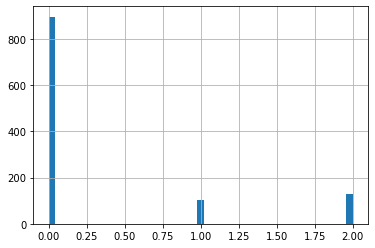

In [21]:
dfres['changecurvecounter'].hist(bins=45)

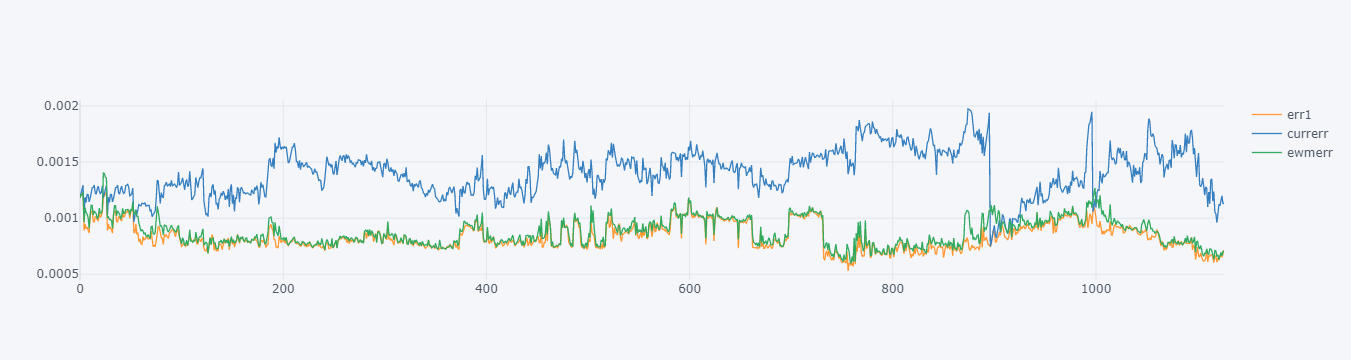

In [22]:
dfres[['err1','currerr','ewmerr']].iplot()

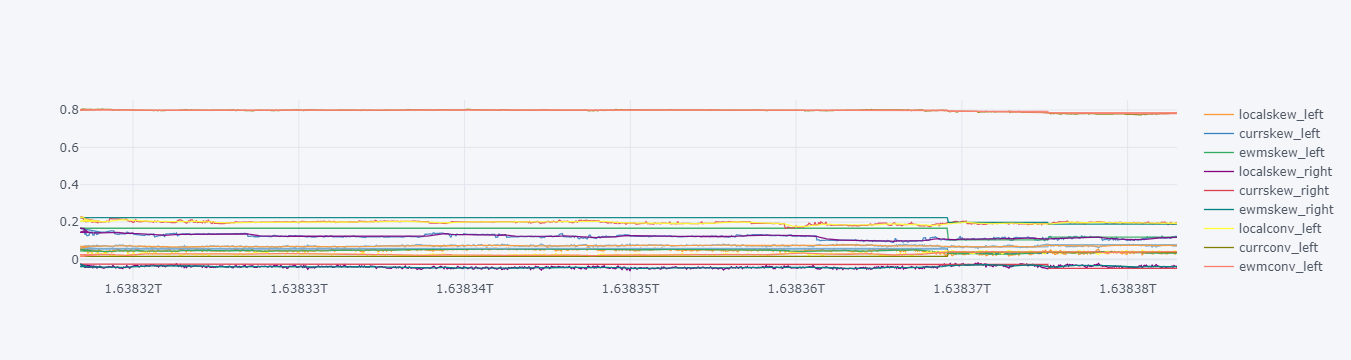

In [23]:
dfres.set_index('t',drop=True)[ptoplot].iplot()

In [27]:
dfres.head()

,t,expire,df,localcurve,currcurve,err1,err2,currerr,changecurvecounter,localATM,...,currrightwing,ewmrightwing,localleftwing,currleftwing,ewmleftwing,localvol_atm,currvol_atm,ewmvol_atm,ewm_x,ewmerr
0,1638316800000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001184,0.001184,0.001184,0,0.799385,...,0.16671,0.166710,0.224187,0.224187,0.224187,0.799385,0.799385,0.799385,"[0.05706715921572881, -0.025751727294213003, 0...",0.001184
1,1638316860000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001212,0.001223,0.001223,0,0.801711,...,0.16671,0.165828,0.227992,0.224187,0.226190,0.801711,0.799385,0.800609,"[0.05493853329443952, -0.02816033204865347, 0....",0.001209
2,1638316920000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001220,0.001243,0.001243,0,0.804564,...,0.16671,0.165982,0.226379,0.224187,0.226259,0.804564,0.799385,0.802068,"[0.05298096702008353, -0.031457025298720694, 0...",0.001206
3,1638316980000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.001231,0.001294,0.001294,0,0.805277,...,0.16671,0.165040,0.226319,0.224187,0.226277,0.805277,0.799385,0.803001,"[0.05097690203764352, -0.03303911600487141, 0....",0.001229
4,1638317040000,1640937600000,ty s aiv biv ve...,<cryptoderiv_quantlib.volatility.data_objects....,<cryptoderiv_quantlib.volatility.data_objects....,0.000890,0.001027,0.001027,0,0.803137,...,0.16671,0.165249,0.205955,0.224187,0.221314,0.803137,0.799385,0.803034,"[0.05136363459274742, -0.03417262733001953, 0....",0.000964


In [34]:
len(dfres['localcurve'])

In [38]:
dfres['localcurve'][0].params

{'skew_left': 0.05706715921572881,
 'skew_right': -0.025751727294213003,
 'conv_left': 0.015705629140172088,
 'conv_right': 0.05909604206894494,
 'rightwing': 0.16671031852197268,
 'leftwing': 0.2241872198597274,
 'vol_atm': 0.7993849925000001,
 'ref_forward': 57406.67,
 'fitness_error': 0.0011839137296786638,
 'kleft': -1.5,
 'kright': 1.5}

In [39]:
params_dict = {}
for i in range(len(dfres['localcurve'])):
    params_dict[i] = dfres['localcurve'][i].params

In [43]:
df_parames = pd.DataFrame(params_dict).T

In [46]:
df_parames.head()

,skew_left,skew_right,conv_left,conv_right,rightwing,leftwing,vol_atm,ref_forward,fitness_error,kleft,kright
0,0.057067,-0.025752,0.015706,0.059096,0.166710,0.224187,0.799385,57406.67,0.001184,-1.5,1.5
1,0.053023,-0.030328,0.015209,0.061785,0.165035,0.227992,0.801711,57322.76,0.001212,-1.5,1.5
2,0.049634,-0.037094,0.016146,0.065206,0.166243,0.226379,0.804564,57255.53,0.001220,-1.5,1.5
3,0.046089,-0.036898,0.018077,0.066257,0.162743,0.226319,0.805277,57306.97,0.001231,-1.5,1.5
4,0.052561,-0.037681,0.017589,0.066871,0.165896,0.205955,0.803137,57386.49,0.000890,-1.5,1.5


In [56]:
def getTEvents(gRaw,h):
    tEvents = []
    sPos = 0
    sNeg = 0
    diff=gRaw.diff()
    for i in diff.index[1:]:
        sPos = max(0,sPos+diff.loc[i])
        sNeg = min(0,sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg=0;
            tEvents.append(i)
        elif sPos>h:
            sPos=0;
            tEvents.append(i)
    # return pd.DatetimeIndex(tEvents)
    return tEvents

In [60]:
getTEvents(df_parames['skew_left'], 0.02)

[8,
 19,
 31,
 42,
 61,
 124,
 345,
 534,
 549,
 684,
 834,
 875,
 893,
 921,
 927,
 950,
 957,
 958,
 959,
 991,
 1003,
 1009,
 1012,
 1045,
 1054]